In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Optimization Algorithms with Adaptive Learning Rates

In this section, we investigate learning algorithms that adapt the learning rate during training. We will see that this can lead to faster convergence and better generalization. We will start by discussing the intuition and basic concepts behind adaptive learning rates. Then, we will introduce the AdaGrad algorithm and discuss its strengths and weaknesses. Finally, we will introduce the RMSProp and Adam algorithms, which are currently the most popular adaptive learning rate algorithms.

# The delta-bar-delta rule

The first adaptive learning algorithm was [Jacobs (1988)](https://www.sciencedirect.com/science/article/abs/pii/0893608088900032), called the "delta-bar-delta" rule.
The idea is as follows:

+ Each parameter has its own learning rate, which is updated at each iteration.
+ If the gradient has the same sign as the previous iteration, then the learning rate is increased. We can move faster.
+ If the gradient has the opposite sign as the previous iteration, then the learning rate is decreased. We are probably oscillating around a local minimum.

This algorithm is not used anymore, but it was the first step towards adaptive learning rates.


## The Adaptive Gradient Algorithm: AdaGrad

The AdaGrad algorithm was introduced by [Duchi et al. (2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf).
The idea is to adapt the learning rate of each weight based on the history of the gradients of that weight.

The algorithm is as follows:

+ Initialize the learning rate $\alpha$ and the parameters $x_0$.
+ For $t=0,1,2,\ldots$:
    + Compute the gradient $g_t$.
    + Accumulate the squared gradient: $r_t = r_{t-1} + g_t^2$.
    + Update the parameters: $x_{t+1} = x_t - \frac{\alpha}{\sqrt{r_t + \epsilon}} g_t$.

The intuition is as follows:

+ If the gradient for a parameter is large for the long time, then we have updated quite a lot. So, we should decrease the learning rate.
+ If the gradient for a parameter is small for a long time, then we have not updated much. So, we should increase the learning rate.

In general, AdaGrad does not work very well. The main problem is that the learning rate is monotonically decreasing. So, it becomes very small after a while. This means that the algorithm stops learning. Don't use it.


## Root Mean Square Propagation (RMSProp)

The RMSProp was introduced by Hinton in his course on Coursera, see [here](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).
It in unpublished as of now. The goal was to fix the problems of AdaGrad.
Instead of just accumulating the squared gradients, we take a moving average of the squared gradients.

The algorithm is as follows:

+ Initialize the learning rate $\alpha$ and the parameters $x_0$.
+ For $t=0,1,2,\ldots$:
    + Compute the gradient $g_t$.
    + Accumulate the squared gradient: $r_t = \beta r_{t-1} + (1-\beta) g_t^2$.
    + Update the parameters: $x_{t+1} = x_t - \frac{\alpha}{\sqrt{r_t + \epsilon}} g_t$.

You can use this algorithm with Nestorov momentum. It works quite well.

## Adaptive Moment Estimation (Adam)

The Adam algorithm was introduced by [Kingma and Ba (2014)](https://arxiv.org/abs/1412.6980).
It is one of the most popular algorithms for training neural networks.
It combines the ideas of RMSProp and momentum.

The algorithm is as follows:

+ Initialize the learning rate $\alpha$, the parameters $x_0$, and the momentum parameters $v_0$ and $r_0$.
+ For $t=0,1,2,\ldots$:
    + Compute the gradient $g_t$.
    + Update the momentum: $v_t = \beta_1 v_{t-1} + (1-\beta_1) g_t$.
    + Update the squared gradient: $r_t = \beta_2 r_{t-1} + (1-\beta_2) g_t^2$.
    + Correct the momentum: $\hat{v}_t = \frac{v_t}{1-\beta_1^t}$.
    + Correct the squared gradient: $\hat{r}_t = \frac{r_t}{1-\beta_2^t}$.
    + Update the parameters: $x_{t+1} = x_t - \frac{\alpha}{\sqrt{\hat{r}_t + \epsilon}} \hat{v}_t$.

The hyperparameters are $\alpha$, $\beta_1$, $\beta_2$, and $\epsilon$.
Their constraints are:

+ $\alpha > 0$. Typically, $\alpha \in [0.001, 0.1]$.
+ $\beta_1 \in [0,1)$. Typically, $\beta_1 = 0.9$.
+ $\beta_2 \in [0,1)$. Typically, $\beta_2 = 0.999$.
+ $\epsilon > 0$. Typically, $\epsilon = 10^{-8}$.

The above should not look very strange to you by now.
The only new thing is that we correct the momentum and the squared gradient.
This is because the momentum and the squared gradient are initialized to zero.
So, they are biased towards zero at the beginning.
The correction is to remove this bias.
For example, consider the effect of the $(1 - \beta_t^t)^{-1}$ term on the momentum $v_t$.
Let's pick the first step $t=1$.
We have $v_0 = 0$, so:

$$
\begin{align}
v_1 &= \beta_1 v_0 + (1-\beta_1) g_1 \\
&= (1-\beta_1) g_1,
\end{align}
$$

So, when we remove the bias, we get:

$$
\hat{v}_1 = \frac{v_1}{1-\beta_1} = g_1.
$$

Here is how the algorithm looks in our previous example:

In [2]:
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)

# Generate some synthetic data
N = 1_000
X = jrandom.normal(key, (N,))
key, subkey = jrandom.split(key)
y = 1.5 * X ** 2 - 2 * X + jrandom.normal(subkey, (N,)) * 0.5

# Make also a test set (here an ideal one)
N_test = 50
X_test = jnp.linspace(-3, 3, N_test)
key, subkey = jrandom.split(key)
y_test = 1.5 * X_test ** 2 - 2 * X_test + jrandom.normal(subkey, (N_test,)) * 0.5

import numpy as np
import equinox as eqx
import jax
import optax
from functools import partial


class MyModel(eqx.Module):
    theta: jax.Array

    def __init__(self, key):
        self.theta = jax.random.normal(key, (3,))
    
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        return self.theta @ jnp.array([1, x, x ** 2])
    
# The function below generates batches of data
def data_generator(X, y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

# This is the training loop
def train_batch(
        model,
        x, y,
        optimizer,
        x_test, y_test,
        n_batch=10,
        n_epochs=10,
        freq=1,
    ):
    
    # This is the loss function
    @eqx.filter_jit
    def loss(model, x, y):
        y_pred = model(x)
        return optax.l2_loss(y_pred, y).mean()

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(model)
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    # The path of the test accuracy
    test_losses = []
    for e in range(n_epochs):
        for i, (xb, yb) in enumerate(data_generator(x, y, n_batch)):
            model, opt_state, value = step(opt_state, model, xb, yb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                test_losses.append(loss(model, x_test, y_test))
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {test_losses[-1]:.3f}")
    return model, path, losses, test_losses

In [3]:
key, subkey = jrandom.split(key)

model = MyModel(subkey)

optimizer = optax.adam(0.01, b1=0.9, b2=0.999, eps=1e-8)

model, path, losses, test_losses = train_batch(
    model,
    X, y,
    optimizer,
    X_test, y_test,
    n_batch=10,
    n_epochs=20,
    freq=1,
)

Epoch 0, step 0, loss 8.558, test 53.878
Epoch 0, step 1, loss 17.129, test 53.367
Epoch 0, step 2, loss 11.738, test 52.857
Epoch 0, step 3, loss 6.788, test 52.379
Epoch 0, step 4, loss 13.663, test 51.892
Epoch 0, step 5, loss 7.179, test 51.423
Epoch 0, step 6, loss 4.807, test 50.989
Epoch 0, step 7, loss 5.841, test 50.567
Epoch 0, step 8, loss 55.429, test 50.179
Epoch 0, step 9, loss 5.403, test 49.819
Epoch 0, step 10, loss 21.629, test 49.438
Epoch 0, step 11, loss 22.163, test 49.038
Epoch 0, step 12, loss 14.392, test 48.639
Epoch 0, step 13, loss 5.079, test 48.267
Epoch 0, step 14, loss 17.560, test 47.883
Epoch 0, step 15, loss 9.189, test 47.514
Epoch 0, step 16, loss 6.508, test 47.164
Epoch 0, step 17, loss 13.302, test 46.813
Epoch 0, step 18, loss 9.209, test 46.471
Epoch 0, step 19, loss 11.351, test 46.130
Epoch 0, step 20, loss 5.735, test 45.806
Epoch 0, step 21, loss 32.043, test 45.435
Epoch 0, step 22, loss 76.224, test 45.011
Epoch 0, step 23, loss 10.929, t

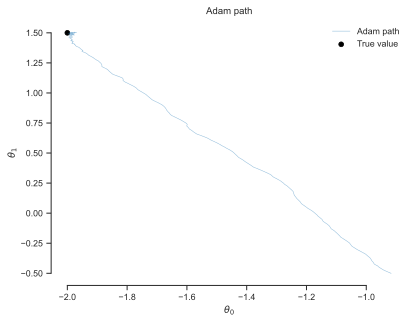

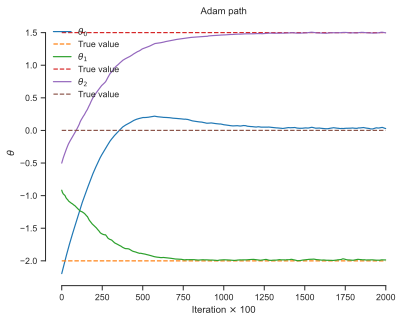

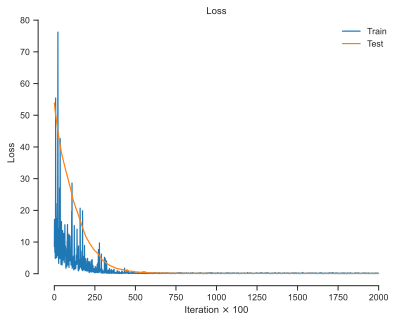

In [4]:
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="Adam path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="Adam path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration $\\times$ 100", ylabel=r"$\theta$", title="Adam path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# The losses
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

The good thing about Adam is that it works well in practice without much tuning.
So, you can use it as a default algorithm.

Some additional notes:

+ You can use learning decay with Adam if you wish. But the effective learning rate of Adam decays automatically anyway as the gradients become smaller. So, there is really no need for learning decay.

+ Another variant of Adam is called [Nadam](http://cs229.stanford.edu/proj2015/054_report.pdf). It is Adam with Nesterov momentum. I have not seen any evidence that it works better than Adam.

+ Yet another variant is [AdamW](https://arxiv.org/abs/1711.05101). It is Adam with weight decay. This algorithm is pulling the parameters towards zero. It has an effect similar to L2 regularization. You can try it if your intention is to minimize a loss function plus L2 regularization. What I mean by that is that you can use AdamW instead of Adam and remove the L2 regularization term from the loss function. Otherwise it's kind of like double regularization. You should not use AdamW if you want to minimize a specific objective function.